In [1]:
%cd ..
%matplotlib nbagg

/usr/users/promo2019/ramzi_eli/work/mnistconfidnet


In [2]:
import sys
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as T
from sklearn.metrics import accuracy_score

from model import ConvNet, ConfidNet
from utils import ConfidenceHistograms

In [5]:
DEVICE = "cuda"
BATCH_SIZE = 32

In [6]:
conv_net = ConvNet().to(DEVICE)
conv_net.load_state_dict(torch.load("/usr/users/promo2019/ramzi_eli/experiments/ConfidNet/first_experiment/model/ConvNet_1.pth"))
conv_net.eval()

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [18]:
train_valid_dataset = torchvision.datasets.MNIST(
    root=Path("~/datasets/MNIST").expanduser(),
    train=True,
    transform=T.ToTensor(),
    download=True)
nb_train = int(.3 * len(train_valid_dataset))
nb_valid = len(train_valid_dataset) - nb_train
train, val = torch.utils.data.dataset.random_split(
    train_valid_dataset, [nb_train, nb_valid])

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val, batch_size=BATCH_SIZE)

In [8]:
imgs, label = next(iter(train_loader))
imgs, label = imgs.to(DEVICE), label.to(DEVICE)

with torch.no_grad():
    pred, encoded = conv_net(imgs)

In [9]:
# check to make sure we have examples of wrong prediction
F.softmax(pred, dim=1).argmax(1) == label

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True], device='cuda:0')

In [11]:
confid_net = ConfidNet(small=True).to(DEVICE)
optimizer = Adam(confid_net.parameters())
criterion = torch.nn.MSELoss()

In [12]:
epoch = 2000
epoch_to_restore = 0


train_histograms = ConfidenceHistograms()
history_train = {"loss": [], "metric": []}
for e in range(epoch_to_restore + 1, epoch + epoch_to_restore + 1):
    confid_net.train()

    confid_net.zero_grad()
    confidence = confid_net(encoded)
    loss = criterion(confidence, F.softmax(pred, dim=1).gather(1, label.unsqueeze(1)))
    loss.backward()
    optimizer.step()
    history_train["loss"].append(loss.detach().item())
    train_histograms.step(label, pred, confidence.detach())

    sys.stdout.write(
        "Training : "
        f"Epoch {e}/{epoch + epoch_to_restore}; "
        f"Loss {loss.detach().item()};\r"
    )
    sys.stdout.flush()

<IPython.core.display.Javascript object>


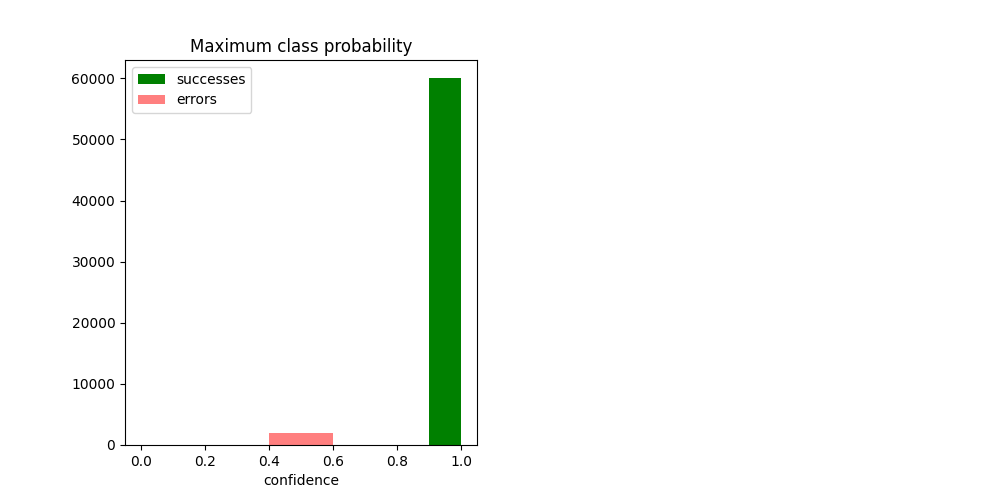

<IPython.core.display.Javascript object>


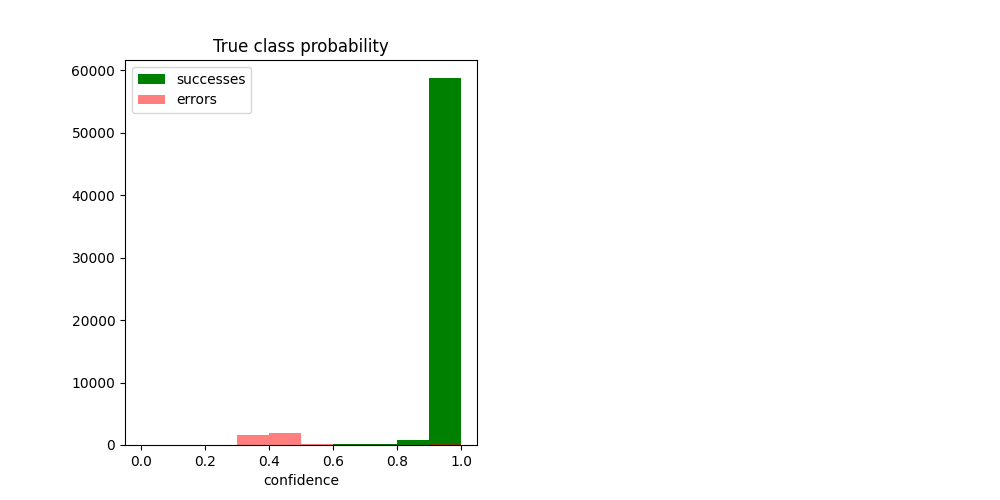

In [13]:
mcp, tcp = train_histograms.get_histograms()

### Fit on entirer training set

In [14]:
class MLPNet(nn.Module):
    def __init__(self, input_size=784, hidden_size=128):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size,)
        self.fc2 = nn.Linear(hidden_size, 10)
        self.fc_dropout = nn.Dropout(0.3)

    def forward(self, x):
        out = x.view(-1, self.input_size)
        out = F.relu(self.fc1(out))
        out = self.fc_dropout(out)

        pred = self.fc2(out)
        return pred, out

In [19]:
net = MLPNet().to(DEVICE)
optimizer = Adam(net.parameters())
criterion = torch.nn.CrossEntropyLoss()

epoch = 1
epoch_to_restore = 0

for e in range(epoch_to_restore + 1, epoch + epoch_to_restore + 1):
    net.train()
    history_train = {"loss": [], "metric": []}
    for idx_batch, (imgs, label) in enumerate(train_loader):
        imgs, label = imgs.to(DEVICE), label.to(DEVICE)

        net.zero_grad()
        pred, _ = net(imgs)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        history_train["loss"].append(loss.detach().item())

        pred = F.softmax(pred.detach(), dim=1).argmax(1)
        score = accuracy_score(label.cpu(), pred.cpu())
        history_train["metric"].append(score)

        step = min((idx_batch+1) * 32, len(train))
        sys.stdout.write(
            "Training : "
            f"Epoch {e}/{epoch + epoch_to_restore}; "
            f"Step {step}/{len(train)}; "
            f"Loss {loss.detach().item()}; "
            f"Score {score}\r"
        )
        sys.stdout.flush()
        
    print(
        f"\n\n[*] Finished epoch {e};\n\n"
        "Train :\n"
        f"\tLoss : {np.mean(history_train['loss'])}\n"
        f"\tAccuracy : {np.mean(history_train['metric'])}\n\n"
    )

Training : Epoch 1/1; Step 18000/18000; Loss 0.7435215711593628; Score 0.875255

[*] Finished epoch 1;

Train :
	Loss : 0.5503830757011953
	Accuracy : 0.8475244227353463




In [20]:
confid_net = ConfidNet(small=False).to(DEVICE)
optimizer = Adam(confid_net.parameters())
criterion = torch.nn.MSELoss()

In [21]:
epoch = 40
epoch_to_restore = 0

net.eval()
for e in range(epoch_to_restore + 1, epoch + epoch_to_restore + 1):
    confid_net.train()
    history_train = {"loss": [], "metric": []}
    train_histograms = ConfidenceHistograms()
    for idx_batch, (imgs, label) in enumerate(train_loader):
        imgs, label = imgs.to(DEVICE), label.to(DEVICE)
        with torch.no_grad():
            pred, encoded = net(imgs)

        confid_net.zero_grad()
        confidence = confid_net(encoded)
        loss = criterion(confidence, F.softmax(pred, dim=1).gather(1, label.unsqueeze(1)))
        loss.backward()
        optimizer.step()
        train_histograms.step(label, pred, confidence.detach())
        history_train["loss"].append(loss.detach().item())

        step = min((idx_batch+1) * 32, len(train))
        sys.stdout.write(
            "Training : "
            f"Epoch {e}/{epoch + epoch_to_restore}; "
            f"Step {step}/{len(train)}; "
            f"Loss {loss.detach().item()};\r"
        )
        sys.stdout.flush()
    
    print(
        f"\n\n[*] Finished epoch {e};\n\n"
        "Train :\n"
        f"\tLoss : {np.mean(history_train['loss'])}\n\n"
    )

Training : Epoch 1/40; Step 18000/18000; Loss 0.002169942017644644;;

[*] Finished epoch 1;

Train :
	Loss : 0.02820245460995852


Training : Epoch 2/40; Step 18000/18000; Loss 0.014070586301386356;;

[*] Finished epoch 2;

Train :
	Loss : 0.016533035544064854


Training : Epoch 3/40; Step 18000/18000; Loss 0.008405530825257301;;

[*] Finished epoch 3;

Train :
	Loss : 0.014216778681718547


Training : Epoch 4/40; Step 18000/18000; Loss 0.008370145224034786;;

[*] Finished epoch 4;

Train :
	Loss : 0.012664016841978602


Training : Epoch 5/40; Step 18000/18000; Loss 0.10950955003499985;;;

[*] Finished epoch 5;

Train :
	Loss : 0.011634412706760544


Training : Epoch 6/40; Step 18000/18000; Loss 0.0012015048414468765;

[*] Finished epoch 6;

Train :
	Loss : 0.011181875000824426


Training : Epoch 7/40; Step 18000/18000; Loss 0.010182308964431286;;

[*] Finished epoch 7;

Train :
	Loss : 0.010447540351989486


Training : Epoch 8/40; Step 18000/18000; Loss 0.007550711277872324;;

[*] Fin

<IPython.core.display.Javascript object>


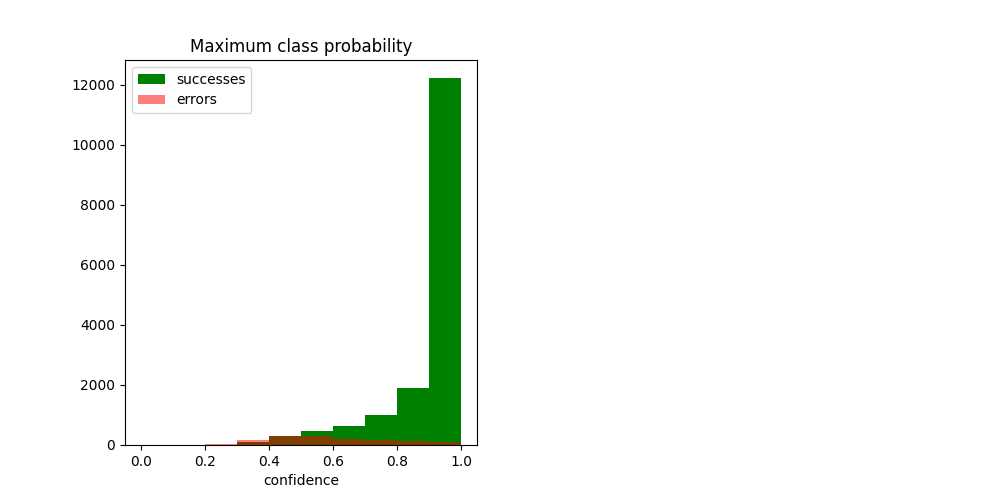

<IPython.core.display.Javascript object>


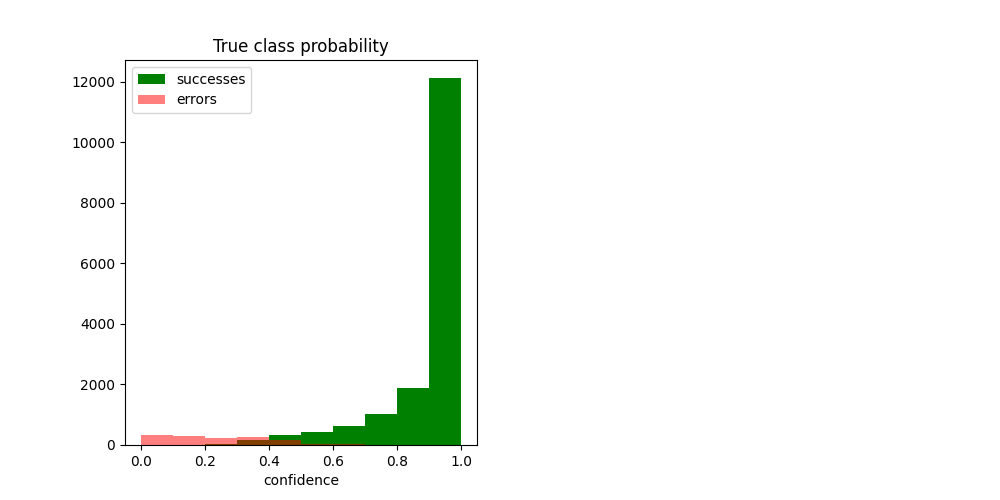

In [22]:
mcp, tcp = train_histograms.get_histograms()